#  TSMapEstimator vs. ExcessMapEstimator

This notebooks compares the results of the full likelihood fitting approach ("forward folding") against the Li&Ma solution of the same problem ("backwards folding"). The results are expected to be approximately equivalent in case of using a disk kernel for the `TSMapEstimator` and neclecting the effect of the PSF.

The remaining difference is that while the `ExcessMapEstimator` sums all counts and computes flux based on the mean exposure in the same region, the `TSMapEstimator` takes into account the full pixel by pixel information.

Results:
- The results are indeed approximately equivalent 
- On average the `TSMapEstimator` find slightly higher errors because it takes into account the fluctuations per pixel
- The `ExcessMapEstimator` is faster by a factor of 50-100 for ordinary flux and error estimation. Once assymetric errors and ULs are computed the `TSMapEstimator` shows the better performance and is ~2-3 times faster. When taking multiprocessing into account it is even faster by a factor of ~10.

In [1]:
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    SkyModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    DiskSpatialModel,
)
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

In [2]:
dataset = MapDataset.read(
    "$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz", name="cta_dataset"
)
dataset.psf = None

In [3]:
est = ExcessMapEstimator(
    correlation_radius="0.1 deg",
)

model = SkyModel(
    spectral_model=PowerLawSpectralModel(),
    spatial_model=DiskSpatialModel(r_0="0.1 deg"),
)

ts_est = TSMapEstimator(
    model=model,
    sum_over_energy_groups=True,
)

In [4]:
est_all = ExcessMapEstimator(
    correlation_radius="0.1 deg", selection_optional="all"
)


ts_est_all = TSMapEstimator(
    model=model,
    sum_over_energy_groups=True,
    selection_optional="all",
    n_jobs=8,
)

In [5]:
%%time
result = est.run(dataset=dataset)

CPU times: user 112 ms, sys: 21 ms, total: 133 ms
Wall time: 133 ms


In [6]:
%%time
result_ts = ts_est.run(dataset)

CPU times: user 9.66 s, sys: 138 ms, total: 9.8 s
Wall time: 9.82 s


In [7]:
%%time
result = est_all.run(dataset=dataset)

CPU times: user 3min 37s, sys: 1.77 s, total: 3min 38s
Wall time: 3min 40s


In [8]:
%%time
result_ts = ts_est_all.run(dataset)

CPU times: user 1.51 s, sys: 253 ms, total: 1.77 s
Wall time: 16.9 s


In [9]:
def plot_side_by_side(m_1, m_2, **kwargs):
    fig = plt.figure(figsize=(14, 12))
    ax1 = plt.subplot(221, projection=m_1.geom.wcs)
    ax2 = plt.subplot(222, projection=m_1.geom.wcs)
    ax3 = plt.subplot(223, projection=m_1.geom.wcs)
    ax4 = plt.subplot(224)

    m_1.plot(ax1, **kwargs)
    ax1.set_title("ExcessMapEstimator")

    m_2.plot(ax2, **kwargs)
    ax2.set_title("TSMapEstimator")

    ax4.scatter(m_1.data.flat, m_2.data.flat, s=2, alpha=0.05)
    ax4.set_title("Correlation")
    ax4.set_xlabel("ExcessMapEstimator")
    ax4.set_ylabel("TSMapEstimator")
    ax4.set_xlim(kwargs["vmin"], kwargs["vmax"])
    ax4.set_ylim(kwargs["vmin"], kwargs["vmax"])
    x = np.linspace(kwargs["vmin"], kwargs["vmax"], 3)
    ax4.plot(x, x, color="k")
    ax4.set_aspect("equal")

    diff = m_1 - m_2
    vmax = -0.1 * kwargs["vmax"]
    diff.plot(
        ax=ax3,
        cmap="RdBu",
        stretch="linear",
        add_cbar=True,
        vmin=-vmax,
        vmax=vmax,
    )
    ax3.set_title("Difference (ExcessMap - TSMap)")

## Flux

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


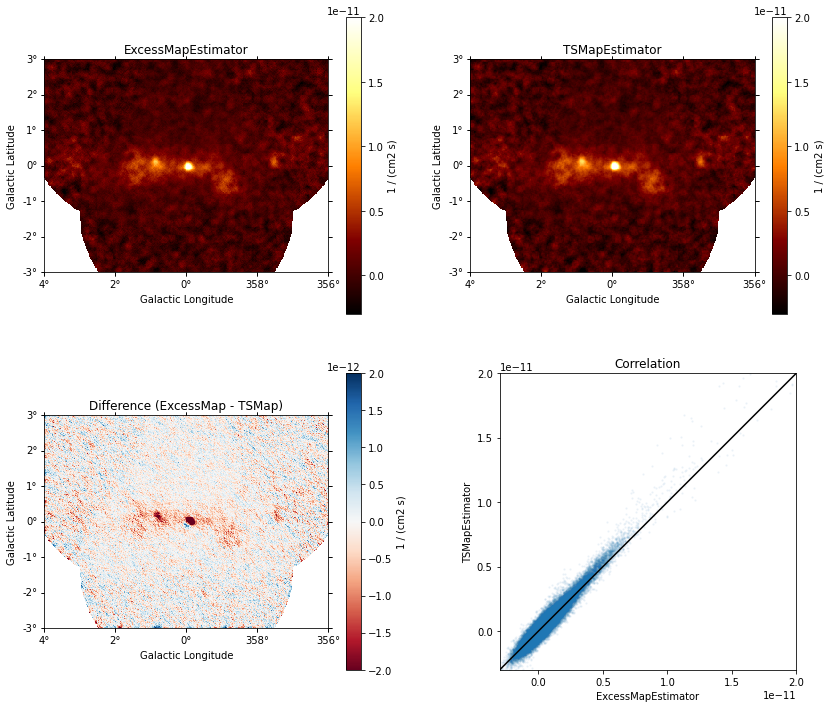

In [10]:
plot_side_by_side(
    result.flux, result_ts.flux, add_cbar=True, vmin=-0.3e-11, vmax=2e-11
);

## Flux Error

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


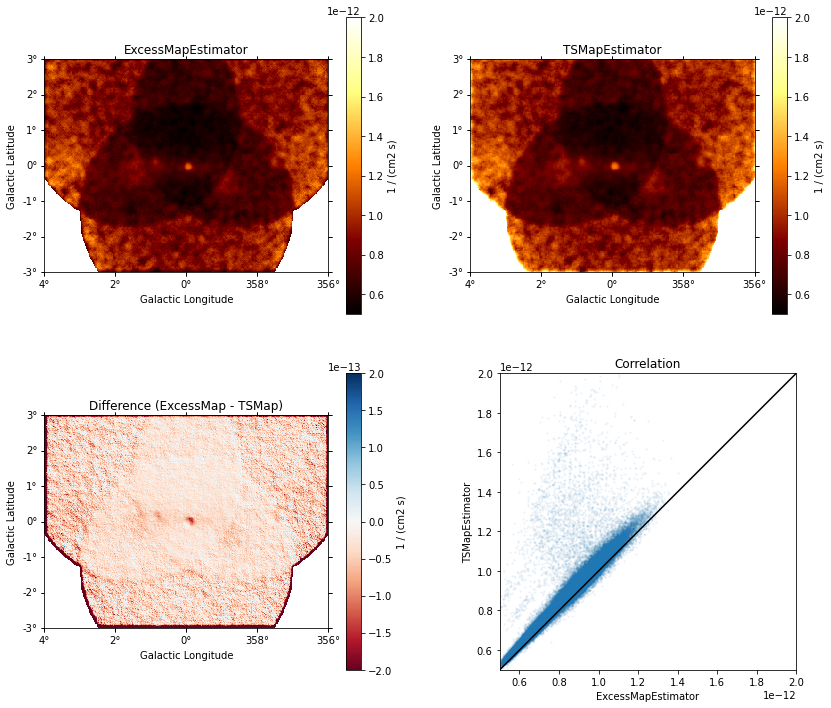

In [11]:
plot_side_by_side(
    result.flux_err,
    result_ts.flux_err,
    add_cbar=True,
    vmin=0.5e-12,
    vmax=2e-12,
);

## Flux UL

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


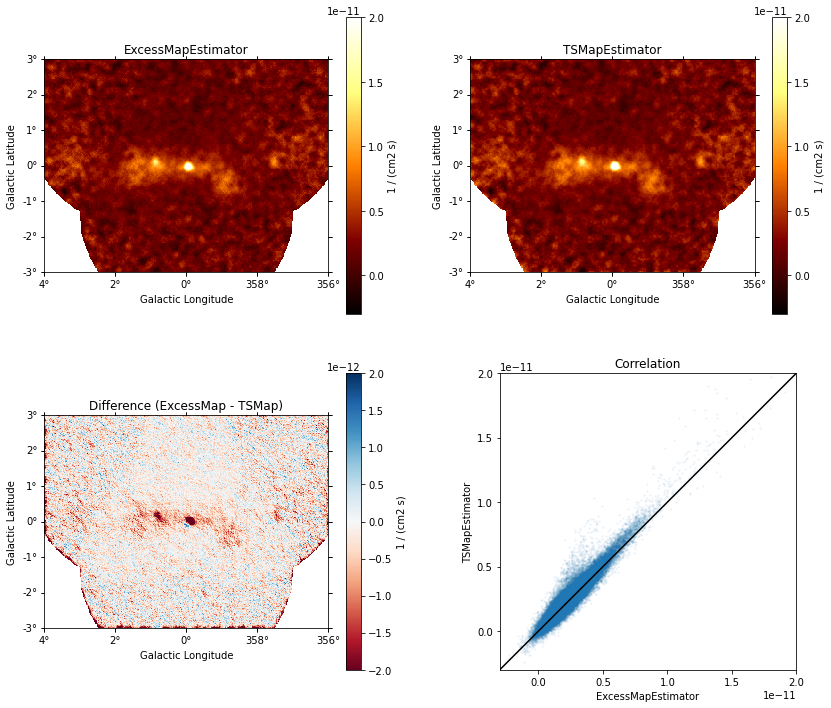

In [12]:
plot_side_by_side(
    result.flux_ul, result_ts.flux_ul, add_cbar=True, vmin=-0.3e-11, vmax=2e-11
);

## Flux Error Pos.

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


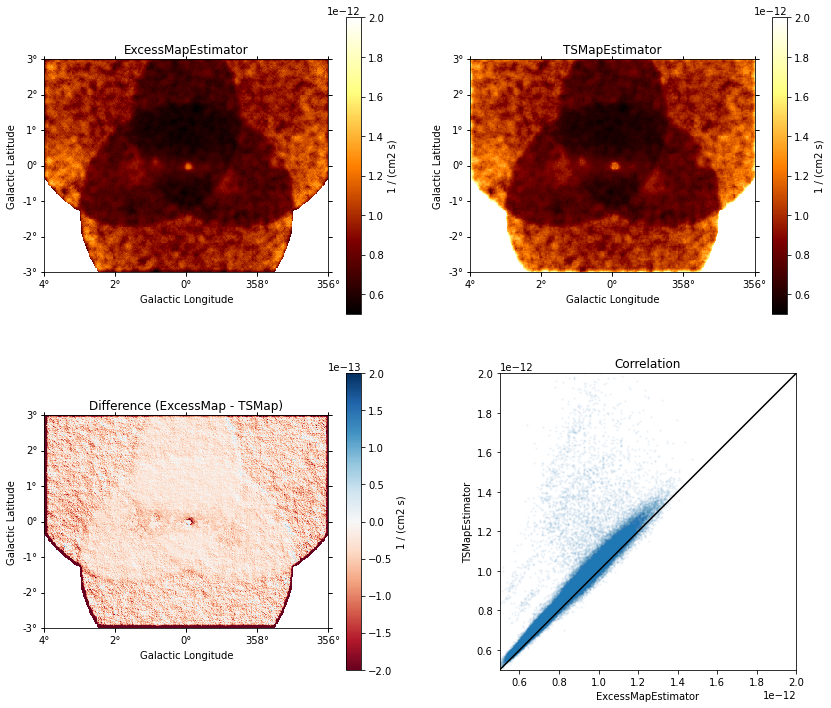

In [13]:
plot_side_by_side(
    result.flux_errp,
    result_ts.flux_errp,
    add_cbar=True,
    vmin=0.5e-12,
    vmax=2e-12,
);

## Flux Error Neg.

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


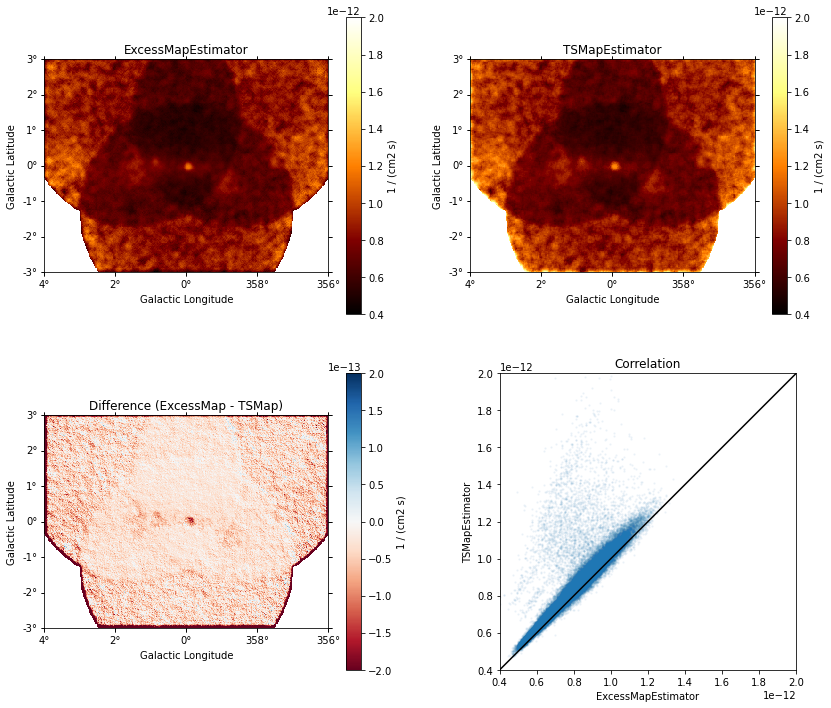

In [14]:
# result._data["norm_errn"].data *= -1

plot_side_by_side(
    result.flux_errn,
    result_ts.flux_errn,
    add_cbar=True,
    vmin=0.4e-12,
    vmax=2e-12,
);

## Sqrt(TS)

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


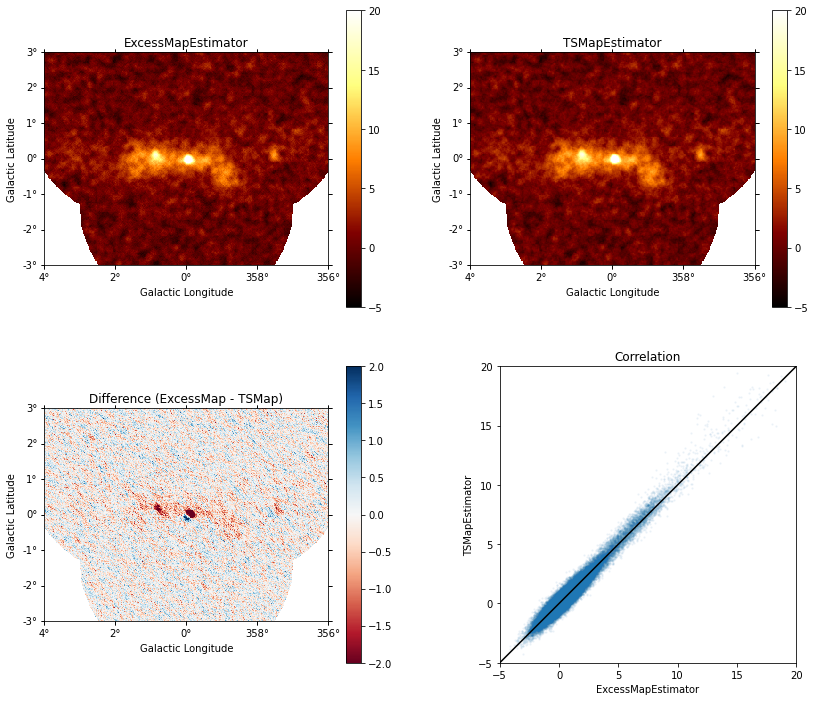

In [15]:
plot_side_by_side(
    result.sqrt_ts,
    result_ts.sqrt_ts,
    add_cbar=True,
    vmin=-5,
    vmax=20,
    stretch="linear",
);

## NPred Excess

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


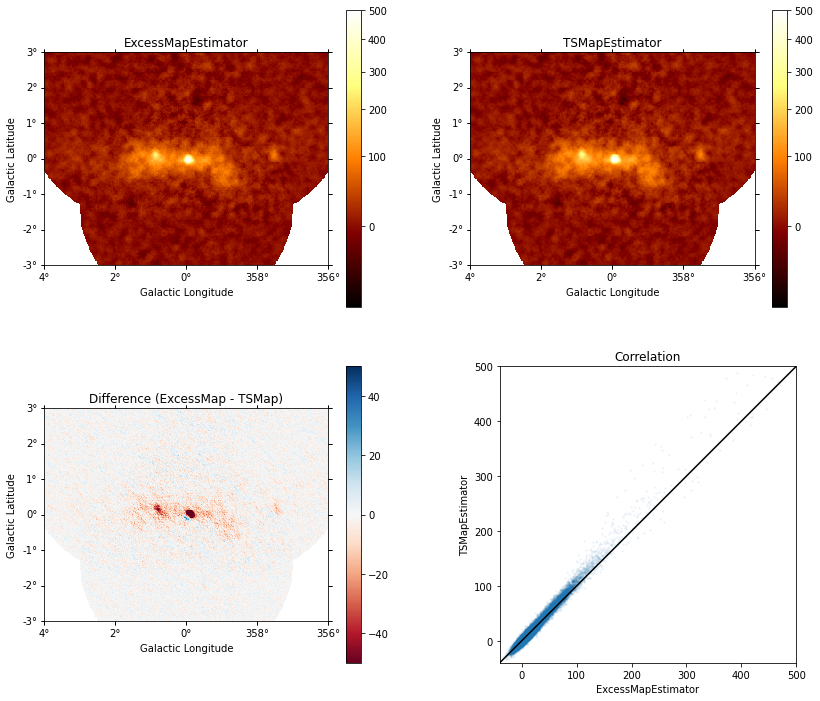

In [16]:
plot_side_by_side(
    result.npred_excess,
    result_ts.npred_excess,
    add_cbar=True,
    vmin=-40,
    vmax=500,
    stretch="sqrt",
);

## NPred Ref.

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


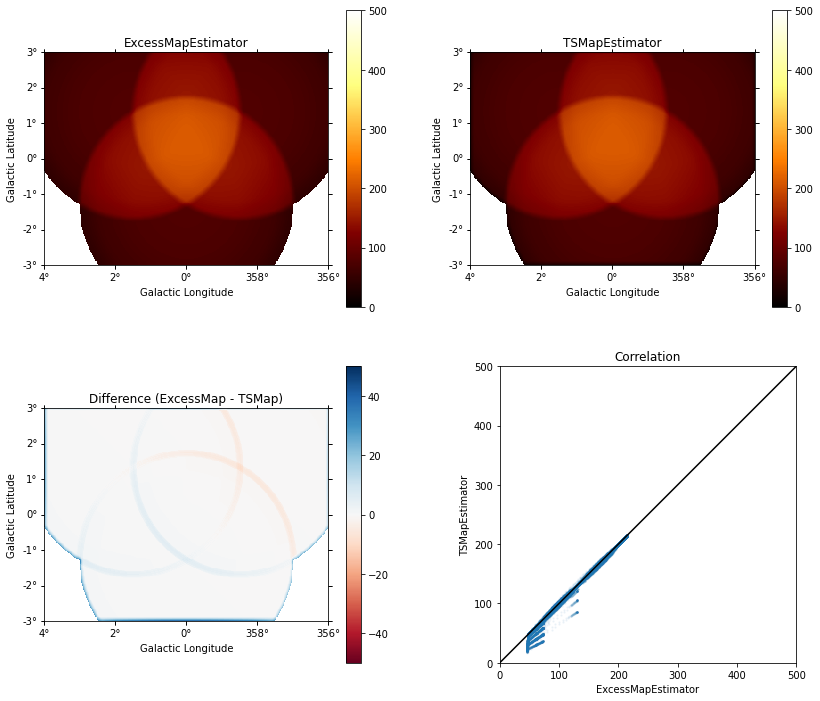

In [17]:
plot_side_by_side(
    result.npred_excess_ref,
    result_ts.npred_excess_ref,
    add_cbar=True,
    vmin=0,
    vmax=500,
);

## NPred Err

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


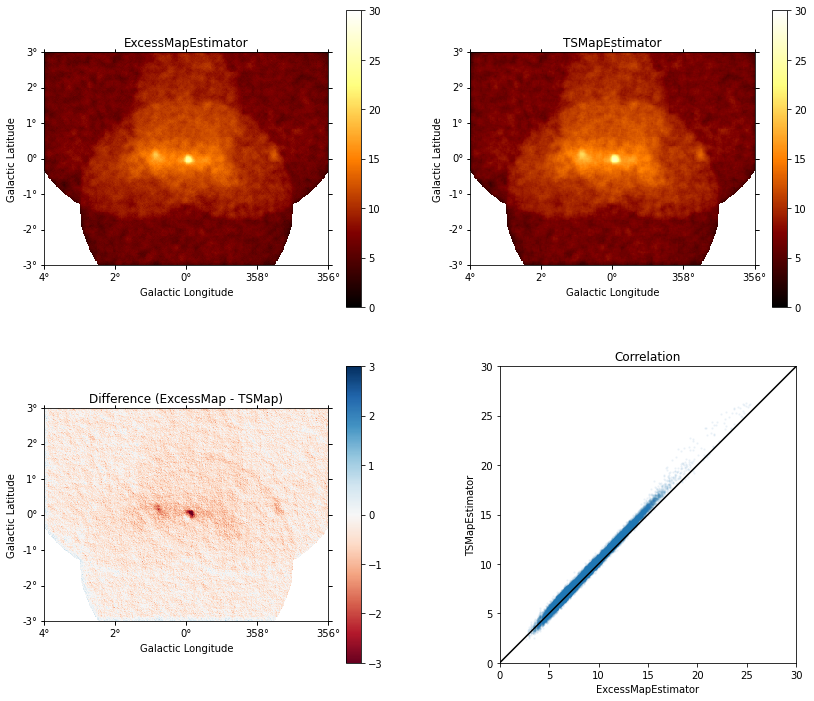

In [18]:
plot_side_by_side(
    result.npred_excess_err,
    result_ts.npred_excess_err,
    add_cbar=True,
    vmin=0,
    vmax=30,
);

## NPred Error Pos.

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


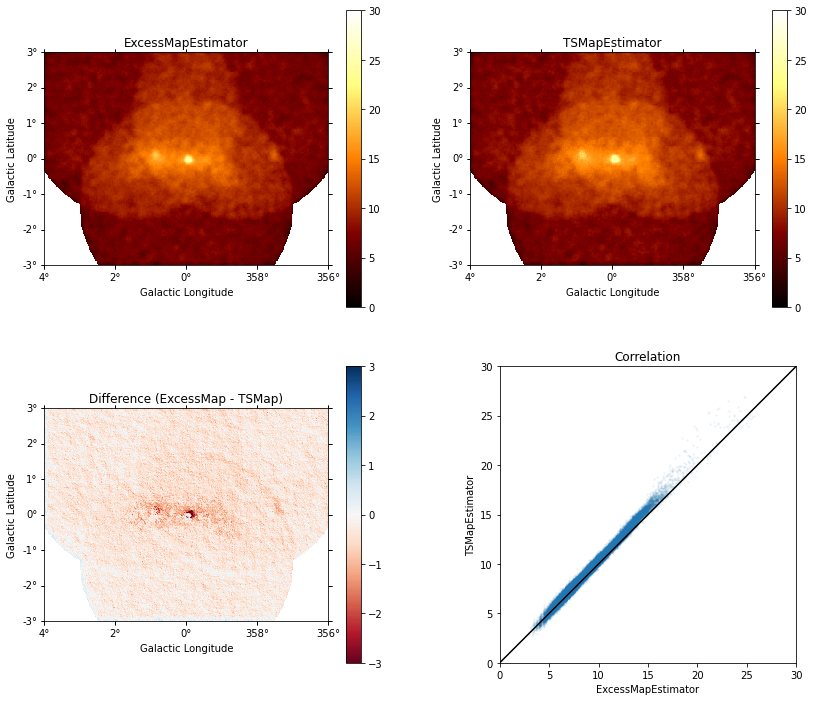

In [19]:
plot_side_by_side(
    result.npred_excess_errp,
    result_ts.npred_excess_errp,
    add_cbar=True,
    vmin=0,
    vmax=30,
);

## NPred Error Neg.

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


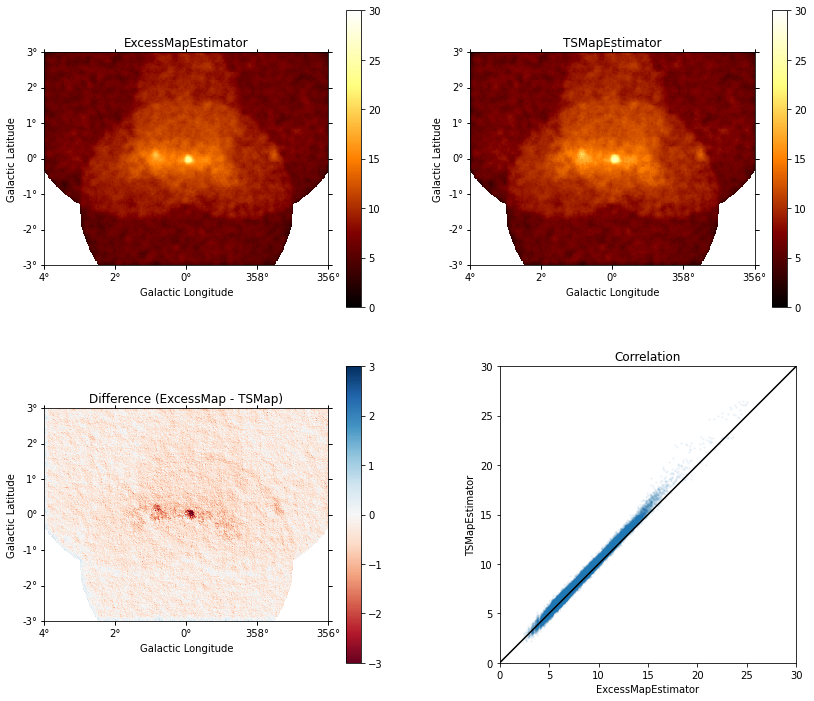

In [20]:
plot_side_by_side(
    result.npred_excess_errn,
    result_ts.npred_excess_errn,
    add_cbar=True,
    vmin=0,
    vmax=30,
);

## NPred UL

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


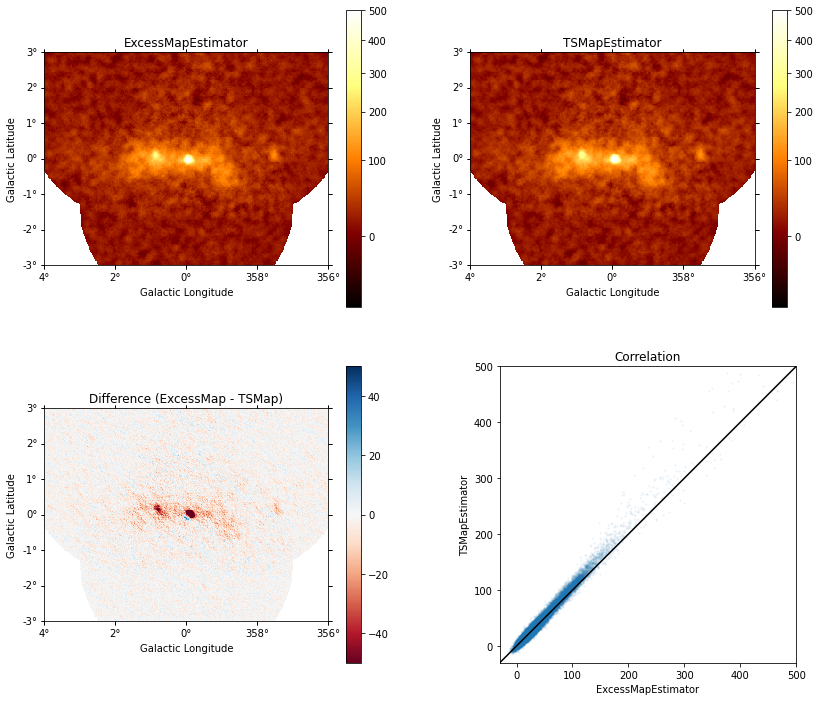

In [21]:
plot_side_by_side(
    result.npred_excess_ul,
    result_ts.npred_excess_ul,
    add_cbar=True,
    vmin=-30,
    vmax=500,
    stretch="sqrt",
);